In [1]:
from qiskit.circuit import *
import numpy as np
from qiskit import Aer, execute, BasicAer
from qiskit.tools.visualization import plot_histogram
from qiskit.circuit.library import MCXGate
# https://arxiv.org/abs/2304.01501

In [2]:
# CONVENTIONS
# -1 quand le coin vaut 1, +1 quand il vaut 0
# q_0 encode le bit de poids le plus faible

# Cycle

### Power of two

In [375]:
def increment(n):
    """Quantum circuit implementing the increment operator of Fig. 4 from https://arxiv.org/abs/2304.01501

    Parameters
    ----------
    n : int
        Number of qubit encoding the position

    Returns
    -------
    qiskit.circuit.quantumcircuit.QuantumCircuit
    """
    q = QuantumRegister(n,name='q')
    qc = QuantumCircuit(q)
    for i in range(n-1):
        qc.mcx(qc.qubits[:n-i-1],q[n-i-1])
    qc.x(q[0])    
    return qc

def preincrement(n,first_method=True):
    """Quantum circuit implementing the pre-increment operator of Fig. 4 from https://arxiv.org/abs/2304.01501

    Parameters
    ----------
    n : int
        Number of qubit encoding the position
    first_method : bool
        Indicates which methods is used, if True it corresponds to the quantum circuit
        of Fig. 4.a, otherwise Fig. 4.b from https://arxiv.org/abs/2304.01501
        
    Returns
    -------
    qiskit.circuit.quantumcircuit.QuantumCircuit
    """
    q = QuantumRegister(n,name='q')
    c = QuantumRegister(1,name='c')
    qc = QuantumCircuit(q,c)
    if first_method:
        qc.mcx([c[0]],q[n-1])
        for i in range(n-1):
            qc.cx(control,q[n-i-2])
    else:
        for i in range(n-1):
            qc.cx(q[i+1],q[i])
        qc.cx(c[0],q[n-1])
        for i in range(n-1):
            qc.cx(q[n-i-1],q[n-i-2])
    return qc
    
def shift_cycle_power_of_two(n,first_method=True):
    """Quantum circuit implementing the shift operator for a cycle whose size is a power of two

    Parameters
    ----------
    n : int
        Number of qubit encoding the position
    first_method : bool
        Indicates which methods is used to build the pre-increment operator
        if True it corresponds to the quantum circuit of Fig. 4.a, otherwise Fig. 4.b 
        from https://arxiv.org/abs/2304.01501

    Returns
    -------
    qiskit.circuit.quantumcircuit.QuantumCircuit
    """
    q = QuantumRegister(n,name='q')
    c = QuantumRegister(1,name='c')
    qc = QuantumCircuit(q,c)
    preincrement_gate = preincrement(n,first_method)
    increment_gate = increment(n)
    qc.append(preincrement_gate,qc.qubits)
    qc.append(increment_gate,qc.qubits[:n])
    qc.append(preincrement_gate,qc.qubits)
    return qc

In [376]:
def run_qc(qc,n_times):
    """Executes a quantum circuit

    Parameters
    ----------
    qc : qiskit.circuit.quantumcircuit.QuantumCircuit
        Quantum circuit to run
    n_times : int
        Number of times to execute it

    Returns
    -------
    dict
    """
    backend = BasicAer.get_backend('qasm_simulator')
    job = execute(qc,backend,shots=n_times)
    return dict(job.result().get_counts(qc))

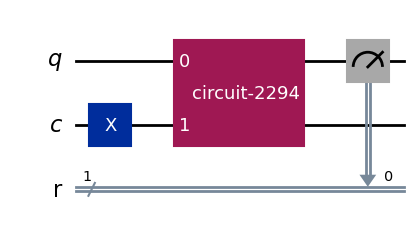

In [397]:
n = 1
q = QuantumRegister(n,name='q')
c = QuantumRegister(1,name='c')
r = ClassicalRegister(n,name='r')
qc = QuantumCircuit(q,c,r)

shift = shift_cycle_power_of_two(n,False)

qc.x(c)
#qc.x(q[2])
qc.append(shift,qc.qubits)
qc.measure(q,r)
qc.decompose(reps=0).draw('mpl',style='iqx')

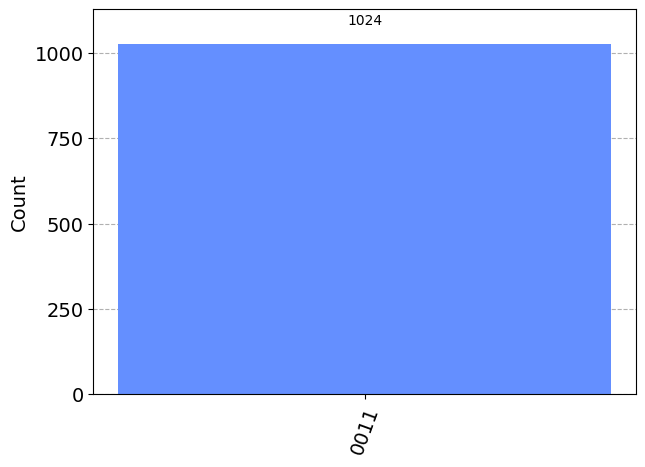

In [378]:
res = run_qc(qc,n_times=1024)
plot_histogram(res)

### Non power of two

In [379]:
def first_transposition_operator(n,index):
    """Return the quantum circuit of all the transposition operators following the first pattern for
    the decrement and increment schemes

    Parameters
    ----------
    n : int
        Number of qubit encoding the position
    index : int
        index-th second transposition operator to implement

    Returns
    -------
    qiskit.circuit.quantumcircuit.QuantumCircuit, qiskit.circuit.quantumcircuit.QuantumCircuit
    """
    index_bin = bin(index)[2:].zfill(n-1)[::-1]
    # decrement circuit
    q_dec = QuantumRegister(n,name='q_dec')
    c_dec = QuantumRegister(1,name='c_dec')
    qc_dec = QuantumCircuit(q_dec,c_dec)
    gate_dec = MCXGate(n,ctrl_state=index_bin+'1')
    qc_dec.append(gate_dec,qc_dec.qubits[::-1])
    # increment circuit
    q_inc = QuantumRegister(n,name='q_inc')
    c_inc = QuantumRegister(1,name='c_inc')
    qc_inc = QuantumCircuit(q_inc,c_inc)
    gate_inc = MCXGate(n,ctrl_state=index_bin+'0')
    qc_inc.append(gate_inc,qc_inc.qubits[::-1])
    return qc_dec, qc_inc

def second_transposition_operator(n,index):
    """Return the quantum circuit of all the transposition operators following the second pattern for
    the decrement and increment schemes

    Parameters
    ----------
    n : int
        Number of qubit encoding the position
    index : int
        index-th second transposition operator to implement

    Returns
    -------
    qiskit.circuit.quantumcircuit.QuantumCircuit, qiskit.circuit.quantumcircuit.QuantumCircuit
    """
    # decrement circuit
    q_dec = QuantumRegister(n,name='q_dec')
    c_dec = QuantumRegister(1,name='c_dec')
    qc_dec = QuantumCircuit(q_dec,c_dec)
    # increment circuit
    q_inc = QuantumRegister(n,name='q_inc')
    c_inc = QuantumRegister(1,name='c_inc')
    qc_inc = QuantumCircuit(q_inc,c_inc)
    if n == 2:
        gate_dec = MCXGate(n,ctrl_state='1'+'1')
        gate_inc = MCXGate(n,ctrl_state='1'+'0')
    else:
        index_bin = bin(index)[2:].zfill(n-2)[::-1]
        gate_dec = MCXGate(n,ctrl_state='1'+index_bin+'1')
        gate_inc = MCXGate(n,ctrl_state='1'+index_bin+'0')
    # 1 SWAP = 3 CNOTs
    qc_dec.append(gate_dec,qc_dec.qubits[::-1])
    qc_dec.append(gate_dec,(qc_dec.qubits[1:2] + qc_dec.qubits[:1] + qc_dec.qubits[2:])[::-1])
    qc_dec.append(gate_dec,qc_dec.qubits[::-1])
    qc_inc.append(gate_inc,qc_inc.qubits[::-1])
    qc_inc.append(gate_inc,(qc_inc.qubits[1:2] + qc_inc.qubits[:1] + qc_inc.qubits[2:])[::-1])
    qc_inc.append(gate_inc,qc_inc.qubits[::-1])
    return qc_dec, qc_inc

def get_third_operator_data(n,third_sequence):
    """Returns a dictionnary of tuples whose keys are the indices of the transposition operators of the
    third kind, the first element of the tuple is the control state of the controlling qubits and the second
    is the value of r

    Parameters
    ----------
    n : int
        Number of qubit encoding the position
    third_sequence : int list
        index-th second transposition operator to implement

    Returns
    -------
    dict
    """
    # d[indice] = (extra_ctrl_state,r)
    n_iter = int(np.log2(1+len(third_sequence)))
    d = {}
    for i in range(n_iter):
        step = 2**(n_iter-i)
        start = len(third_sequence)//2**(i+1)
        for j in range(2**i):
            index = third_sequence[start+step*j]
            if i == 0:
                d[index] = ('',n-i-2)
            else:
                if j%2 == 0:
                    predecessor = index+2**(n_iter-i+1)
                else:
                    predecessor = index-2**(n_iter-i+1)
                d[index] = (d[predecessor][0] + str(j%2),n-i-2)
    return d

def third_transposition_operator(n,r,ctrl_state,coin_ctrl_state):
    """Returns a quantum circuit implementing the transposition operator of third kind whose control
    state is the bit string ctrl_state

    Parameters
    ----------
    n : int
        Number of qubit encoding the position
    r : int
        Number of upper control qubits for the SWAP
    ctrl_state : str
        Bit string representing the control state of the qubits
    coin_ctrl_state : str
        Bit string representing the control state of the coin qubit

    Returns
    -------
    qiskit.circuit.quantumcircuit.QuantumCircuit
    """
    q = QuantumRegister(n,name='q_dec')
    c = QuantumRegister(1,name='c_dec')
    qc = QuantumCircuit(q,c)
    
    for i in range(r):
        qc.cx(q[i+1],q[i])
    
    n_extra_control = n-r-2
    coin_qubit = [qc.qubits[-1]]

    if n_extra_control == 0:
        gate_dec = MCXGate(n,ctrl_state='1'+'0'*r+coin_ctrl_state)
        qubits1 = coin_qubit + qc.qubits[:r+2]
        qubits2 = coin_qubit + qc.qubits[:r] + qc.qubits[r+1:r+2] + qc.qubits[r:r+1]
    else:
        gate_dec = MCXGate(n,ctrl_state='1'+'0'*r+ctrl_state+coin_ctrl_state)
        qubits1 = coin_qubit + qc.qubits[r+2:n] + qc.qubits[:r+2]
        qubits2 = coin_qubit + qc.qubits[r+2:n] + qc.qubits[:r] + qc.qubits[r+1:r+2] + qc.qubits[r:r+1]
    
    qc.append(gate_dec, qubits1)
    qc.append(gate_dec, qubits2)
    qc.append(gate_dec, qubits1)
    for i in range(r):
        qc.cx(q[r-i],q[r-i-1])
    
    return qc

def transposition_operators_list(n,k):
    """Return two lists containing the quantum circuit implementation if the shift for the decrement and
    increment schemes

    Parameters
    ----------
    n : int
        Number of qubit encoding the position
    k : int
        Number of nodes to be included in the graph, k <= 2**n

    Returns
    -------
    qiskit.circuit.quantumcircuit.QuantumCircuit array, qiskit.circuit.quantumcircuit.QuantumCircuit array
    """
    q = QuantumRegister(n,name='q')
    c = QuantumRegister(1,name='c')
    qc = QuantumCircuit(q,c)
    
    first_sequence = [2*j for j in range(2**(n-1))]
    second_sequence = [4*j+1 for j in range(2**(n-2))]
    third_sequence = [4*j+3 for j in range(2**(n-2)-1)]
    
    third_sequence_dict = get_third_operator_data(n,third_sequence)
    transposition_operators_decrement_list = [None]*(k-1)
    transposition_operators_increment_list = [None]*(k-1)
    
    first_index = 0
    second_index = 0
    for j in range(k-1):
        if j in first_sequence:
            qc_dec, qc_inc = first_transposition_operator(n,first_index)
            first_index += 1
        elif j in second_sequence:
            qc_dec, qc_inc = second_transposition_operator(n,second_index)
            second_index += 1
        else:
            current_operator = third_sequence_dict[j]
            ctrl_state = current_operator[0] #[::-1]
            r = current_operator[1]
            qc_dec = third_transposition_operator(n,r,ctrl_state,'1')
            qc_inc = third_transposition_operator(n,r,ctrl_state,'0')
        transposition_operators_decrement_list[j] = qc_dec
        transposition_operators_increment_list[j] = qc_inc 
    return transposition_operators_decrement_list, transposition_operators_increment_list

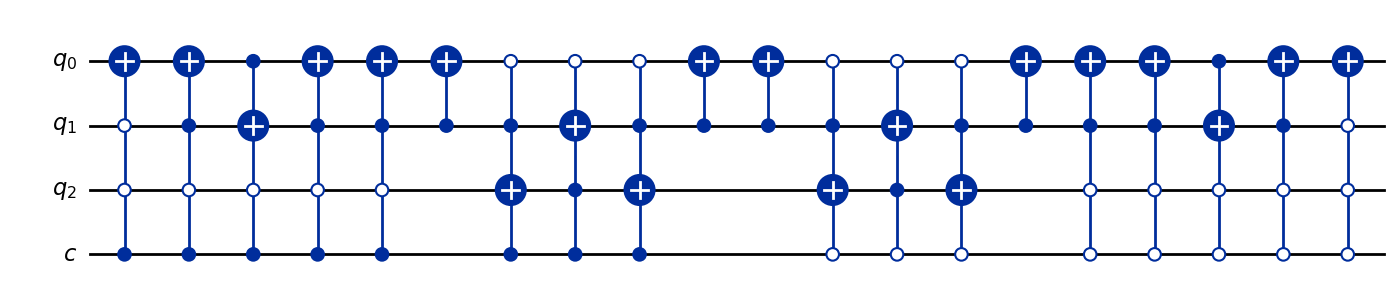

In [380]:
def shift_arbitrary_cycle(n,k):
    """Generates the quantum circuit implementing the shift operator of the arbitrary k-cycle graph
    Parameters
    ----------
    n : int
        Number of qubit encoding the position
    k : int
        Number of nodes to be included in the graph, k <= 2**n

    Returns
    -------
    qiskit.circuit.quantumcircuit.QuantumCircuit array
    """
    q = QuantumRegister(n,name='q')
    c = QuantumRegister(1,name='c')
    qc = QuantumCircuit(q,c)
    if k > 2**n:
        print('k must be smaller or equal to 2**n')
    else:
        
        operators_dec, operators_inc = transposition_operators_list(n,k)
        for i in operators_dec:
            qc.append(i,qc.qubits)
            #qc.barrier()
        #qc.barrier()
        for i in operators_inc[::-1]:
            qc.append(i,qc.qubits)
            #qc.barrier()
    return qc

n = 3
k = 5
qc = shift_cycle_arbitrary(n,k)
qc.decompose(reps=1).draw('mpl',style='iqx')

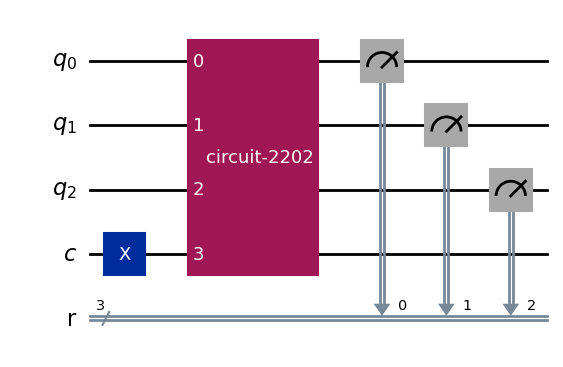

In [386]:
# à vérifier
n = 3
k = 2**n
q = QuantumRegister(n,name='q')
c = QuantumRegister(1,name='c')
r = ClassicalRegister(n,name='r')
qc = QuantumCircuit(q,c,r)

shift = shift_arbitrary_cycle(n,k)

qc.x(c)
#qc.x(q[])
qc.append(shift,qc.qubits)
qc.measure(q,r)
qc.decompose(reps=0).draw('mpl',style='iqx')

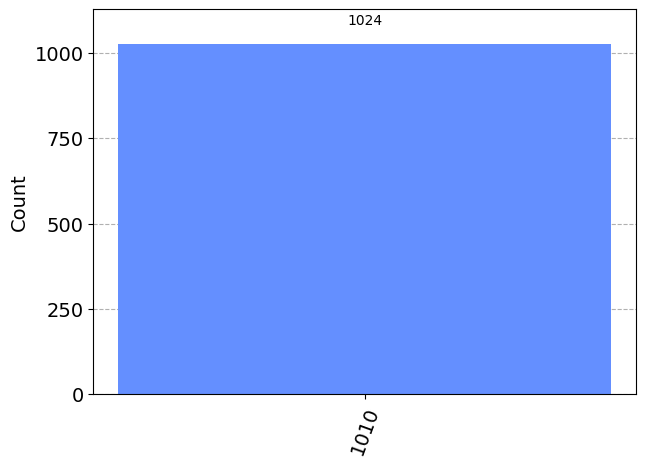

In [382]:
res = run_qc(qc,n_times=1024)
plot_histogram(res)

In [399]:
def shift_cycle(k,first_method=True):
    """Generates the quantum circuit implementing the shift operator of cycle graph with k nodes, note
    that k can be any arbitrary integer greater than 0
    ----------
    k : int
        Number of nodes in the graph
    first_method : bool
        Indicates which methods is used, if True it corresponds to the quantum circuit
        of Fig. 4.a, otherwise Fig. 4.b from https://arxiv.org/abs/2304.01501

    Returns
    -------
    qiskit.circuit.quantumcircuit.QuantumCircuit
    """
    if k == 0:
        print('The number of nodes must be greater than 0')
    else:
        if k == 1:
            n = 1
        else:
            n = int(np.ceil(np.log2(k)))
        q = QuantumRegister(n,name='q')
        c = QuantumRegister(1,name='c')
        qc = QuantumCircuit(q,c)
        if (k & (k-1) == 0) and k != 0:
            shift = shift_cycle_power_of_two(n,first_method=first_method)
        else:
            shift = shift_arbitrary_cycle(n,k)
        qc.append(shift,qc.qubits)
        return qc

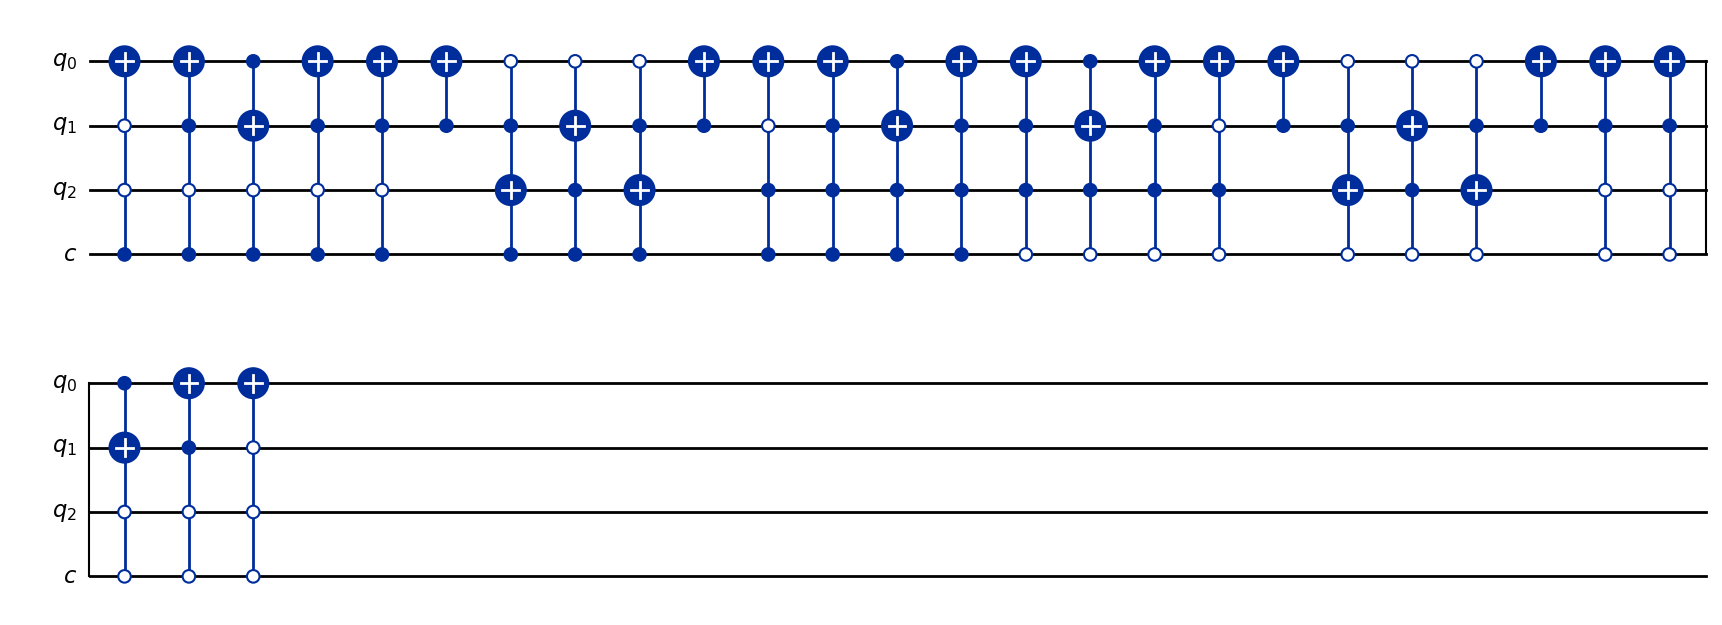

In [401]:
k = 7
qc = shift_cycle(k)
qc.decompose(reps=2).draw('mpl',style='iqx')